# <font color='green'><b> OPTICAL FLOW </b></font>


### Credits: Hands-on Image Processing with Python, Chapter 7 - Author: Sandipan Dey

In [11]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'CV/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = '../data/img/'
  vid_dir = '../data/video/'
  out_dir = '../data/output/'

print("Current dir:", os.getcwd())

Current dir: /Users/raffaella/Library/CloudStorage/OneDrive-UniversitàdegliStudidiMilano/Raffaella Unimi/materiale didattica/Visione Artificiale/Visione-Artificiale-2023-24/PARTE I /Labs/Lab07_Motion


In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os 
import time
from ipywidgets import interact
import ipywidgets as widgets


In [3]:
#visualization of image sequence
def showVideo(I):
  
  n = len(I)

  def view_image(idx):
    plt.imshow(I[idx-1], interpolation='nearest', cmap='gray')
  
  interact(view_image, idx=widgets.IntSlider(min=1, max=n, step=1, value=1))

# **- Dense Optical Flow in openCV**

OpenCV provides the implementation of the *Gunner Farneback's algorithm* ("Two-Frame Motion Estimation Based on Polynomial Expansion" by Gunner Farneback in 2003).
 
The dense optical flow provides for each pixel the corresponding optical flow vector, *(u,v)*. 
Given this vector, we find their magnitude and direction, and adopt this color code for better visualization. Direction corresponds to Hue value of the image. Magnitude corresponds to Value plane. 

 
`flow	=	cv.calcOpticalFlowFarneback(	prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags	)`



**Parameters**

- *prev*:	first 8-bit single-channel input image.
- *next*:	second input image of the same size and the same type as prev.
- *flow*: [output]	computed flow image that has the same size as prev and type CV_32FC2.
- *pyr_scale*: specifying the image scale (< 1)  to build pyramids for each image; pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.
- *levels*:	number of pyramid layers including the initial image; levels=1 means that no extra layers are created and only the original images are used.
- *winsize*:	averaging window size; larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.
- *iterations*:	number of iterations the algorithm does at each pyramid level.
- *poly_n*:	size of the pixel neighborhood used to find polynomial expansion in each pixel; larger values mean that the image will be approximated with smoother surfaces, yielding more robust algorithm and more blurred motion field, typically poly_n =5 or 7.
- *poly_sigma*	standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion; for poly_n=5, you can set poly_sigma=1.1, for poly_n=7, a good value would be poly_sigma=1.5.
- *flags*:	operation flags that can be a combination of the following:
  - OPTFLOW_USE_INITIAL_FLOW uses the input flow as an initial flow approximation.
  - OPTFLOW_FARNEBACK_GAUSSIAN uses the Gaussian 𝚠𝚒𝚗𝚜𝚒𝚣𝚎×𝚠𝚒𝚗𝚜𝚒𝚣𝚎 filter instead of a box filter of the same size for optical flow estimation; usually, this option gives a more accurate flow than with a box filter, at the cost of lower speed; normally, winsize for a Gaussian window should be set to a larger value to achieve the same level of robustness.
The function finds an optical flow for each prev pixel   so that $𝚙𝚛𝚎𝚟(y,x)∼𝚗𝚎𝚡𝚝(y+𝚏𝚕𝚘𝚠(y,x)[1],x+𝚏𝚕𝚘𝚠(y,x)[0])$

In [4]:
def  OFvisualization(flow):
  #for visualization purpose, create a hsv frame of the same dimension as the rgb frame
  hsv = np.zeros_like(frame1)

  #set the saturation to 255
  hsv[:,:,1] = 255 
  mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
    
  hsv[:,:,0] = ang*180/np.pi/2
  hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  
  return rgb


In [5]:
def plot_quiver(ax, flow, spacing, margin=0, **kwargs):
    """Plots less dense quiver field.

    Args:
        ax: Matplotlib axis
        flow: motion vectors
        spacing: space (px) between each arrow in grid
        margin: width (px) of enclosing region without arrows
        kwargs: quiver kwargs (default: angles="xy", scale_units="xy")
    """
    h, w, *_ = flow.shape

    nx = int((w - 2 * margin) / spacing)
    ny = int((h - 2 * margin) / spacing)

    x = np.linspace(margin, w - margin - 1, nx, dtype=np.int64)
    y = np.linspace(margin, h - margin - 1, ny, dtype=np.int64)

    flow = flow[np.ix_(y, x)]
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs}
    ax.quiver(x, y, u, v, **kwargs)

    ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
    ax.set_aspect("equal")

## Exercise 1

Write a function that, given the flow of an image produce the magnitude 


In [6]:
def OFmagVisualization(flow):
  mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
  return mag

In [13]:
#FLAG TO CHOOSE THE VISUALIZATION MODE
visualization = 1 #0:intensity, 1:colors, 2:vectors

cap = cv2.VideoCapture(vid_dir + 'BraveHeart.avi')

# read the first video frame
ret, frame1 = cap.read()

#convert it to gray levels
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
 

#create an output video:
h,w,d = frame1.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(out_dir+ 'output.avi',fourcc, 20.0, (w,h))

#list to save the OF result, frame by frame for interactive visualization
if visualization ==0:
  I = []
elif visualization ==1:
  colors = []

#START VIDEO PROCESSING: 

#ALTERNATIVE 1: to process the whole video:
#ret = True
#while ret:

#ALTERNATIVE 2: to process only the first N  frames:
i=0;
N = 200;

   #CREATE a structure with the Parameters for Farneback OF 
    # [we use the "dict" (https://www.geeksforgeeks.org/python-dictionary/), 
    #  useful to collect unordered collection of data values]
Farneback_params = dict(pyr_scale = 0.5,
                            levels = 3,
                            winsize = 15,
                            iterations = 3,
                            poly_n = 5,
                            poly_sigma = 1.1,
                            flags = 0)
while i<N:
    i += 1 
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    
    # Farneback OF
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, **Farneback_params)
    
    if visualization ==0:
      intensity = OFmagVisualization(flow)
      I.append(intensity)
    elif visualization ==1:
      #visualization via colors:
      rgb = OFvisualization(flow)
      out.write(rgb)
      colors.append(rgb)
    else:
      #visualization of vectors
      fig, ax = plt.subplots()
      plot_quiver(ax, flow, spacing=10, scale=1, color="#ff44ff")
    
 
    prvs = next.copy()
if visualization ==0:
  showVideo(I)
elif visualization ==1:
  showVideo(colors)

cap.release()
out.release() 

interactive(children=(IntSlider(value=1, description='idx', max=200, min=1), Output()), _dom_classes=('widget-…

## Exercise 2 
Test the Gunner Farneback's algorithm on other videos.
Do the parameters work well on different videos?
Try to modify the `Farneback_params` observing the effects on the OF estimation



# **- Optical flow tracking**

**How to detect good points to track?**

We refer to the Shi Tomasi corner detection:

`corners	=	cv.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance [, corners[, mask[, blockSize[, useHarrisDetector[, k]]]]]`
 
https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541

/var/folders/yb/xbsgcy7569qgnvq1586gs7_r0000gn/T/ipykernel_85607/9838670.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


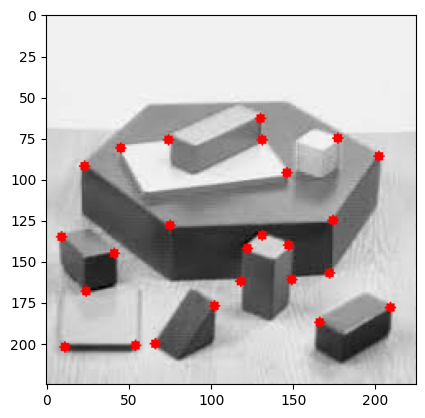

(<matplotlib.image.AxesImage at 0x144241090>, None)

In [14]:
img = cv2.imread(img_dir + 'blox.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

imgShiTomasi = img.copy();

for i in corners:
    x,y = i.ravel()
    cv2.circle(imgShiTomasi,(x,y),3,255,-1)
  
plt.imshow(imgShiTomasi),plt.show()

# **- Exercise 3**

Compute the Harris corner on the same image and compare the results.

HINT: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

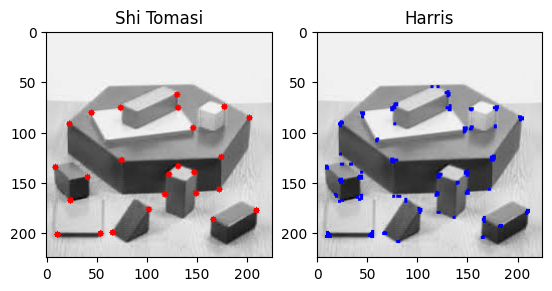

In [15]:
dst = cv2.cornerHarris(gray,2,3,0.04) 
  #Harriscorner params:  
  #   - blockSize	Neighborhood size (see the details on cornerEigenValsAndVecs ).
  #   - ksize	Aperture parameter for the Sobel operator.
  #   - k	Harris detector free parameter. See the formula above.

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
imgHarris = img.copy();
imgHarris[dst>0.01*dst.max()]=[0,0,255]

plt.subplot(121), plt.imshow(imgShiTomasi), plt.title("Shi Tomasi");   
plt.subplot(122), plt.imshow(imgHarris),  plt.title("Harris")
plt.show()

**1. Preliminars for VIDEO TRACKING**

- Parameter setting

In [16]:
#PRELIMINARS and SETTINGS:

#1. OPEN a video file
cap = cv2.VideoCapture(vid_dir + 'traffic.mp4')

#2. CREATE a structure with the Parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
 
#3. CREATE a structure also with the Parameters for Lucas Kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 10, 0.03)) 

# Create some random colors
color = np.random.randint(0,255,(100,3))
nFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(nFrames)

914.0


- Initialization: Corner detection

Next frame to process: 1.0


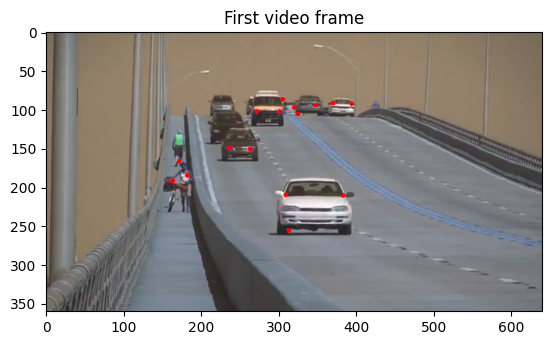

Number of good features to track: 16
Next frame to process: 2.0


In [18]:
# Take first frame and find corners in it
#cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
print("Next frame to process: "+  str(cap.get(cv2.CAP_PROP_POS_FRAMES)))
ret, old_frame = cap.read()
 
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
imgShiTomasi = old_frame.copy()

p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
for i in p0:
    x,y = i.ravel()
    cv2.circle(imgShiTomasi,(int(x),int(y)),3,255,-1)

 
plt.imshow(imgShiTomasi)
plt.title("First video frame"),plt.show()

print("Number of good features to track: "+ str(len(p0)))
print("Next frame to process: "+  str(cap.get(cv2.CAP_PROP_POS_FRAMES)))



**2. Compute the Optical Flow FRAME BY FRAME**

The function:
`nextPts, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, None, **lk_params)`

calculates an optical flow for a sparse feature set using the iterative Lucas-Kanade method with pyramids.

**Some Parameters**

- **INPUT**
  
  - *prevImg*:	first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid.
  - *nextImg*:	second input image or pyramid of the same size and the same type as prevImg.
  - *prevPts*:	vector of 2D points for which the flow needs to be found; point coordinates must be single-precision floating-point numbers.
- **OUTPUT**
  - *nextPts*:	vector of 2D points (with single-precision floating-point coordinates) containing the calculated new positions of input features in the second image. 
  - *status*:	 status vector (of unsigned chars); each element of the vector is set to 1 if the flow for the corresponding features has been found, otherwise, it is set to 0.
  - *err*: vector of errors; each element of the vector is set to an error for the corresponding feature, type of the error measure can be set in flags parameter; if the flow wasn't found then the error is not defined (use the status parameter to find such cases). 

In [21]:
def drawTracks(mask, color, good_new, good_old):
# draw the tracks
  for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
  return mask

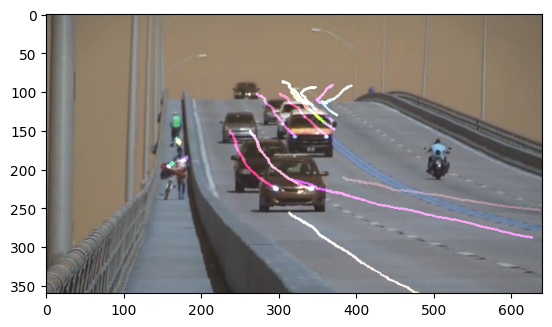

In [22]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

#START VIDEO PROCESSING 

#ALTERNATIVE 1: to process the whole video:
#ret = True
#while ret:

#ALTERNATIVE 2: to process only the first N  frames:
count=0;
N = 200;
while count<N:
    count += 1;
    #print("Next frame to process: "+  str(cap.get(cv2.CAP_PROP_POS_FRAMES)))
    ret,frame = cap.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # CALCULATE OPTICAL FLOW
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
     
    #TO TEST the reset of feature to track:
    #if count == 150:
    #  st = np.zeros_like(st)

    if sum(st) != 0:  #good points have been detected
       # Select good points
      good_new = p1[st==1]
      good_old = p0[st==1]
      mask = drawTracks(mask, color, good_new, good_old)
      
      img = cv2.add(frame,mask)

      plt.imshow(img)
       

    else: #NO GOOD POINT HAS BEEN DETECTED: FIND NEW ONES!!!
      p1 = cv2.goodFeaturesToTrack(frame_gray, mask = None, **feature_params)
      good_new = p1.copy() 

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)